In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import sklearn.ensemble
import sklearn.neural_network
import sklearn
from random import sample

highest_level = [86, 7, 27, 36, 69, 70, 85, 104, 121, 148, 156, 163]
middlest_level = [76, 90, 136, 137, 143, 152, 47, 162]

# Data

In [3]:
communication = pd.read_csv("communication.csv", sep=";")
communication = communication.drop_duplicates()
communication.head()

,Sender,Recipient,EventDate
0,17,37,2010-01-02 17:40:10
1,17,136,2010-01-02 17:40:10
2,17,62,2010-01-02 17:40:10
3,17,129,2010-01-02 17:40:10
4,17,32,2010-01-02 17:40:10


In [4]:
reportsto = pd.read_csv("reportsto.csv", sep=";")
# reportsto = reportsto.drop_duplicates()
reportsto.head()

,ID,ReportsToID
0,1,152
1,2,132
2,3,152
3,4,technical email account - not used by employees
4,5,36


In [5]:
reportsto.ReportsToID.unique()

array(['152', '132', 'technical email account - not used by employees',
       '36', '163', '86', '85', '148', '104', '31', '39', '70', '136',
       '27', '76', '77', '143', '141', '121', '90', '118', '123', '154',
       'former employee account', '45', '47', '156', '69', '159', '29',
       '33', '124', '19', '162', '129', '137'], dtype=object)

In [6]:
reportsto.loc[(reportsto['ReportsToID'] == 'technical email account - not used by employees', 'ReportsToID')] = 666
reportsto.loc[(reportsto['ReportsToID'] == 'former employee account', 'ReportsToID')] = 999
reportsto[['ReportsToID']] = reportsto[['ReportsToID']].astype(int)

In [7]:
reportsto.ReportsToID.unique()

array([152, 132, 666,  36, 163,  86,  85, 148, 104,  31,  39,  70, 136,
        27,  76,  77, 143, 141, 121,  90, 118, 123, 154, 999,  45,  47,
       156,  69, 159,  29,  33, 124,  19, 162, 129, 137])

In [8]:
edges = []
for row in reportsto.values.tolist():
    edges.append((row[0], row[1]))

nodes = set(reportsto.ID.unique().tolist() + reportsto.ReportsToID.unique().tolist())

In [9]:
G_r = nx.Graph()
G_r.add_nodes_from(nodes)
G_r.add_edges_from(edges)

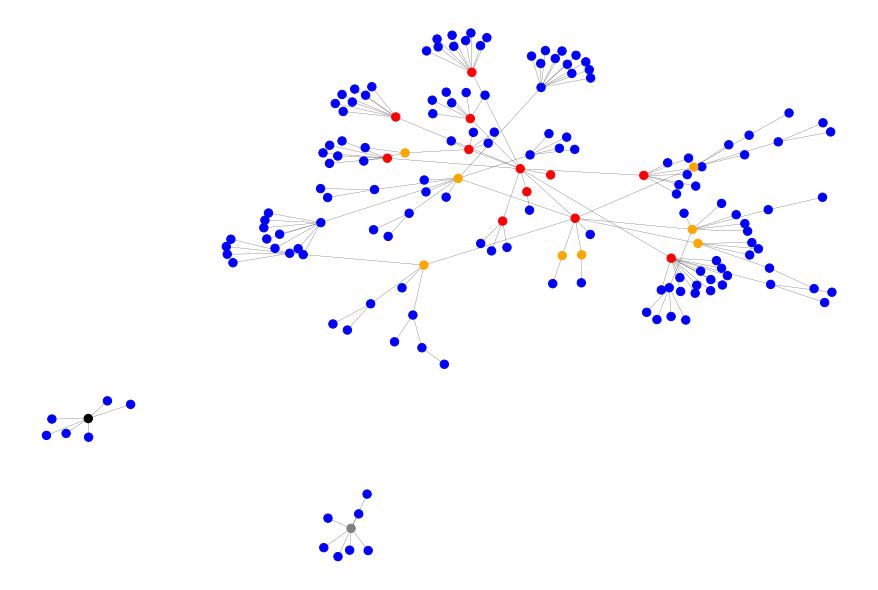

In [10]:
color_map = []
for node in G_r:
    if node in highest_level:
        color_map.append('red')
    elif node in middlest_level:
        color_map.append('orange')
    elif node == 666:
        color_map.append('gray')
    elif node == 999:
        color_map.append('black')
    else:
        color_map.append('blue')
plt.figure(figsize=(12,8))
nx.draw(G_r, node_color=color_map, node_size=70, width=0.2)

In [11]:
edges_с = []
for group, row in communication.groupby(by=["Sender", "Recipient"]):
    edges_с.append((group[0], group[1]))

G_rc = nx.Graph()
G_rc.add_nodes_from(nodes)
G_rc.add_edges_from(set(edges_с + edges))

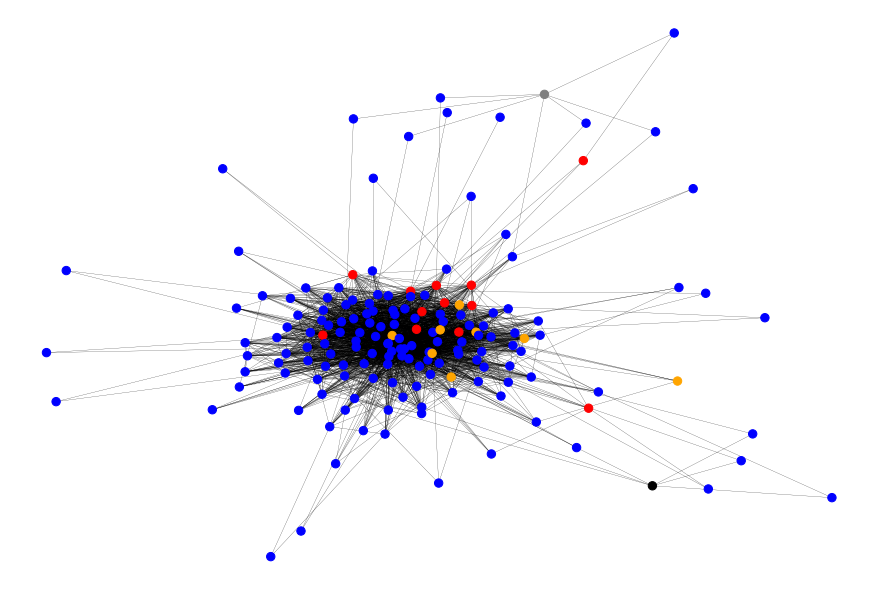

In [12]:
color_map = []
for node in G_rc:
    if node in highest_level:
        color_map.append('red')
    elif node in middlest_level:
        color_map.append('orange')
    elif node == 666:
        color_map.append('gray')
    elif node == 999:
        color_map.append('black')
    else:
        color_map.append('blue')
plt.figure(figsize=(12,8))
nx.draw(G_rc, node_color=color_map, node_size=70, width=0.2)

# Tasks

In [13]:
for node in G_rc:
    if node in highest_level:
        nx.set_node_attributes(G_rc, {node: {'id': node, 'lable': 2}})
    elif node in middlest_level:
        nx.set_node_attributes(G_rc, {node: {'id': node, 'lable': 1}})
    else:
        nx.set_node_attributes(G_rc, {node: {'id': node, 'lable': 0}})

In [14]:
G_rc.nodes[86]

{'id': 86, 'lable': 2}

In [20]:
def update_node(G, node, column_name):
    for a, b in G.edges(node):
        if column_name in G.nodes[b]:
            lable = int(G.nodes[b][column_name])
            new_count = G.nodes[a][f'l{lable}']+1
            nx.set_node_attributes(G, {a: {f'l{lable}': new_count}})


def get_dataframe(G, is_train):
    df = pd.DataFrame()

    for node in G.nodes:
        if is_train == ('uncovered_lable' in G.nodes[node]):
            df = df.append(G.nodes[node], ignore_index=True)

    df.set_index('id', drop=True, inplace=True)
    labels = df['lable']
    df = df[['l0', 'l1', 'l2', 'utility_score']]

    return df, labels


def get_dataframe4random(G, is_train):
    df = pd.DataFrame()

    for node in G.nodes:
        if is_train == ('uncovered_lable' in G.nodes[node]):
            df = df.append(G.nodes[node], ignore_index=True)

    df.set_index('id', drop=True, inplace=True)
    labels = df['lable']
    df = df[['l0', 'l1', 'l2']]

    return df, labels


def get_results(G):
    lables, predicted = [], []

    for node in G.nodes:
        if 'uncovered_lable' not in G.nodes[node]:
            lables.append(G.nodes[node]['lable'])
            predicted.append(G.nodes[node]['predicted'])

    fscore = sklearn.metrics.f1_score(lables, predicted, average='micro')
    confusion_matrix = sklearn.metrics.confusion_matrix(lables, predicted)

    return {'fsc': fscore, 'conf': confusion_matrix}


def classify(Graph, model, percent2uncover, utility_score, reverse, num_iterations=10):
    G = Graph.copy()

    nodes_us = utility_score(G)

    for node, value in nodes_us.items():
        nx.set_node_attributes(G, {node: {'utility_score': value}})

    nodes_us = {k: v for k, v in sorted(nodes_us.items(), key=lambda item: item[1], reverse=reverse)}
    l0, l1, l2 = [], [], []

    num = int(percent2uncover*(G.number_of_nodes()-len(highest_level)-len(middlest_level)))
    num2unc_l0 = num if num > 0 else 1
    num = int(percent2uncover*len(middlest_level))
    num2unc_l1 = num if num > 0 else 1
    num = int(percent2uncover*len(highest_level))
    num2unc_l2 = num if num > 0 else 1
    for k, v in nodes_us.items():
        if k in highest_level:
            if len(l2) < num2unc_l2:
                l2.append(k)
        elif k in middlest_level:
            if len(l1) < num2unc_l1:
                l1.append(k)
        else:
            if len(l0) < num2unc_l0:
                l0.append(k)

        if len(l2) == num2unc_l2 and len(l1) == num2unc_l1 and len(l0) == num2unc_l0:
            break

    uncovered_nodes = l0 + l1 + l2

    for node in G.nodes:
        nx.set_node_attributes(G, {node: {'l0': 0, 'l1': 0, 'l2': 0}})
        if node in uncovered_nodes:
            nx.set_node_attributes(G, {node: {'uncovered_lable': G.nodes[node]['lable']}})

    for node in G.nodes:
        update_node(G, node, 'uncovered_lable')
        # for a, b in G.edges(node):
        #     if 'uncovered_lable' in G.nodes[b]:
        #         lable = int(G.nodes[b]['uncovered_lable'])
        #         new_count = G.nodes[a][f'l{lable}']+1
        #         nx.set_node_attributes(G, {a: {f'l{lable}': new_count}})
    
    train, train_labels = get_dataframe(G, True)
    # print(len(train_labels))

    test, test_labels = get_dataframe(G, False)
    # print(len(test_labels))

    model = model.fit(train[['l0', 'l1', 'l2']], train_labels)
    preds = model.predict(test[['l0', 'l1', 'l2']])

    for node, pred in zip(test.index, preds):
        nx.set_node_attributes(G, {node: {'predicted': int(pred)}})
    
    fsc = get_results(G)['fsc']
    new_fsc = None

    for _ in range(num_iterations):
        for node in sorted(test.index, key=lambda item: test.loc[node, 'utility_score'], reverse=reverse):
            nx.set_node_attributes(G, {node: {'l0': 0, 'l1': 0, 'l2': 0}})
            update_node(G, node, 'uncovered_lable')
            update_node(G, node, 'predicted')

            test.loc[node ,['l0', 'l1', 'l2', 'utility_score']] = [G.nodes[node]['l0'],G.nodes[node]['l1'],G.nodes[node]['l2'],G.nodes[node]['utility_score']]
            prediction = int(model.predict([test.loc[node][['l0', 'l1', 'l2']]])[0])

            if G.nodes[node]['predicted'] != prediction:
                nx.set_node_attributes(G, {node: {'predicted': int(prediction)}})
                has_changed = True

        new_fsc = get_results(G)['fsc']

        if fsc != new_fsc:
            fsc = new_fsc
        else:
            break
    
    return get_results(G)

In [16]:
classify(G_rc, sklearn.ensemble.RandomForestClassifier(), 0.1, nx.betweenness_centrality, False)

{'fsc': 0.6993464052287581,
 'conf': array([[104,   0,  31],
        [  6,   0,   1],
        [  8,   0,   3]])}

In [79]:
repeat = 5
models = {
    'Random Forest': sklearn.ensemble.RandomForestClassifier(),
    'Ada Boost': sklearn.ensemble.AdaBoostClassifier()
}
percents = [0.05, 0.1, 0.2, 0.3]
utility_scores = {
    'betweenness': nx.betweenness_centrality, 
    'clodeness': nx.closeness_centrality, 
    'degree': nx.degree_centrality
}
reverce = [True, False]

In [26]:
results = pd.DataFrame()

for m_k, m_v in models.items():
    for p in percents:
        for us_k, us_v in utility_scores.items():
            for r in reverce:
                fsc = 0.0
                # conf = np.zeros((3,3))
                for i in range(repeat):
                    res = classify(G_rc, m_v, p, us_v, r)
                    fsc += res['fsc']
                    # conf = np.add(conf, np.array(res['conf']))
                fsc /= repeat
                # conf /= repeat
                # conf = conf.astype(int)

                print(m_k, p, us_k, r, fsc)

                results = results.append({
                    'model': m_k,
                    'p2uncover': p,
                    'utility_score': us_k,
                    'reverce': r,
                    'fscore': fsc.copy()
                    # 'confusion_m': conf.copy()
                    }, ignore_index=True)

Random Forest 0.05 betweenness True 0.66625
Random Forest 0.05 betweenness False 0.5175000000000001
Random Forest 0.05 clodeness True 0.66875
Random Forest 0.05 clodeness False 0.8875
Random Forest 0.05 degree True 0.675
Random Forest 0.05 degree False 0.63125
Random Forest 0.1 betweenness True 0.8366013071895425
Random Forest 0.1 betweenness False 0.6091503267973856
Random Forest 0.1 clodeness True 0.7843137254901962
Random Forest 0.1 clodeness False 0.8823529411764707
Random Forest 0.1 degree True 0.7973856209150327
Random Forest 0.1 degree False 0.7124183006535948
Random Forest 0.2 betweenness True 0.8744525547445254
Random Forest 0.2 betweenness False 0.708029197080292
Random Forest 0.2 clodeness True 0.8525547445255475
Random Forest 0.2 clodeness False 0.8759124087591241
Random Forest 0.2 degree True 0.8759124087591241
Random Forest 0.2 degree False 0.3094890510948905
Random Forest 0.3 betweenness True 0.8616666666666667
Random Forest 0.3 betweenness False 0.6233333333333333
Rando

In [27]:
results.to_csv('ica_results.csv')

In [21]:
def classify_random(Graph, model, percent2uncover):
    G = Graph.copy()

    uncovered_nodes = sample(G.nodes, int(G.number_of_nodes()*percent2uncover))

    for node in G.nodes:
        nx.set_node_attributes(G, {node: {'l0': 0, 'l1': 0, 'l2': 0}})
        if node in uncovered_nodes:
            nx.set_node_attributes(G, {node: {'uncovered_lable': G.nodes[node]['lable']}})

    for node in G.nodes:
        update_node(G, node, 'uncovered_lable')

    train, train_labels = get_dataframe4random(G, True)
    # print(len(train_labels))

    test, test_labels = get_dataframe4random(G, False)
    # print(len(test_labels))

    model = model.fit(train[['l0', 'l1', 'l2']], train_labels)
    preds = model.predict(test[['l0', 'l1', 'l2']])

    for node, pred in zip(test.index, preds):
        nx.set_node_attributes(G, {node: {'predicted': int(pred)}})
    
    return get_results(G)

In [22]:
repeat = 5
models = {
    'Random Forest': sklearn.ensemble.RandomForestClassifier(),
    'Ada Boost': sklearn.ensemble.AdaBoostClassifier()
}
percents = [0.05, 0.1, 0.2, 0.3]

results = pd.DataFrame()

for m_k, m_v in models.items():
    for p in percents:
        fsc = 0.0
        # conf = np.zeros((3,3))
        for i in range(repeat):
            res = classify_random(G_rc, m_v, p)
            fsc += res['fsc']
            # conf = np.add(conf, np.array(res['conf']))
        fsc /= repeat
        # conf /= repeat
        # conf = conf.astype(int)

        print(m_k, p, fsc)

        results = results.append({
            'model': m_k,
            'p2uncover': p,
            'fscore': fsc.copy()
            # 'confusion_m': conf.copy()
            }, ignore_index=True)

Random Forest 0.05 0.8521739130434783
Random Forest 0.1 0.8640522875816993
Random Forest 0.2 0.8573529411764707
Random Forest 0.3 0.8504201680672269
Ada Boost 0.05 0.8335403726708075
Ada Boost 0.1 0.8248366013071895
Ada Boost 0.2 0.8014705882352942
Ada Boost 0.3 0.8033613445378152


In [23]:
results.to_csv('random_results.csv')

In [107]:
results_ica = pd.read_csv('ica_results.csv')

In [39]:
results_ica[(results_ica['model'] == 'Random Forest') & (results_ica['utility_score'] == 'betweenness') & (results_ica['reverce'] == 0.0)]

,Unnamed: 0,fscore,model,p2uncover,reverce,utility_score
1,1,0.438750,Random Forest,0.05,0.0,betweenness
7,7,0.609150,Random Forest,0.10,0.0,betweenness
13,13,0.708029,Random Forest,0.20,0.0,betweenness
19,19,0.603333,Random Forest,0.30,0.0,betweenness


In [33]:
results_ica[(results_ica['model'] == 'Random Forest') & (results_ica['utility_score'] == 'betweenness') & results_ica['reverce'] == 1.0]

,Unnamed: 0,fscore,model,p2uncover,reverce,utility_score
0,0,0.667500,Random Forest,0.05,1.0,betweenness
6,6,0.836601,Random Forest,0.10,1.0,betweenness
12,12,0.872993,Random Forest,0.20,1.0,betweenness
18,18,0.856667,Random Forest,0.30,1.0,betweenness


In [73]:
def draw(title, xlabel, df1, df2):
    fig = plt.figure(figsize=(10,5))
    ax = plt.axes()

    plt.title(f"{title}")
    plt.xlabel(xlabel)
    plt.ylabel("F-score")

    # x = range(1, len(df1) + 1)
    plt.xticks(df1.p2uncover.tolist())
    x = df1.p2uncover.tolist()

    ax.plot(x, df1.fscore.tolist(), label=f'Descending')
    ax.plot(x, df2.fscore.tolist(), label=f'Ascending')

    plt.legend()


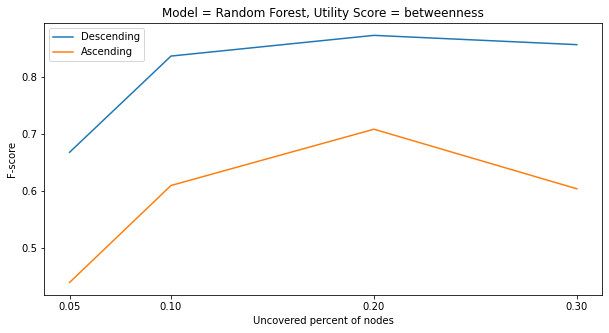

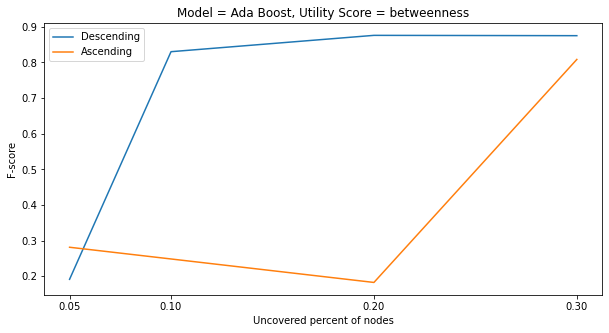

In [92]:
us = list(utility_scores.keys())[0]

for m_k, m_v in models.items():
    draw(f'Model = {m_k}, Utility Score = {us}', 
    'Uncovered percent of nodes', 
    results_ica[(results_ica['model'] == m_k) & (results_ica['utility_score'] == us) & (results_ica['reverce'] == 1.0)],
    results_ica[(results_ica['model'] == m_k) & (results_ica['utility_score'] == us) & (results_ica['reverce'] == 0.0)])

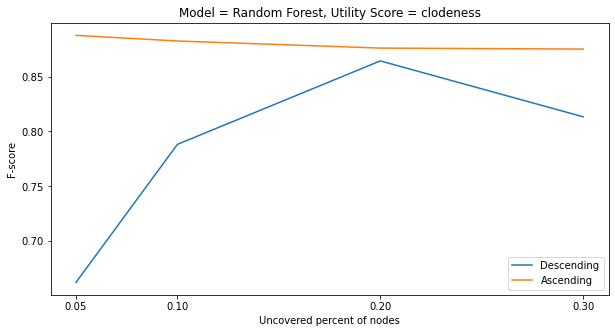

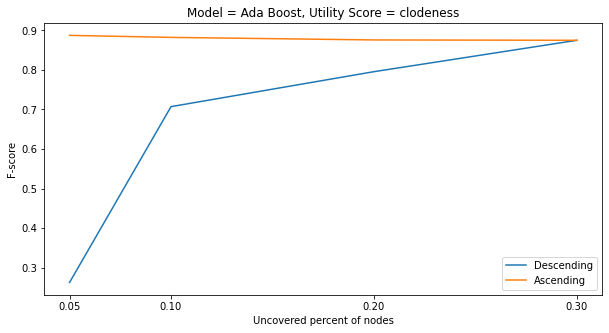

In [91]:
us = list(utility_scores.keys())[1]

for m_k, m_v in models.items():
    draw(f'Model = {m_k}, Utility Score = {us}', 
    'Uncovered percent of nodes', 
    results_ica[(results_ica['model'] == m_k) & (results_ica['utility_score'] == us) & (results_ica['reverce'] == 1.0)],
    results_ica[(results_ica['model'] == m_k) & (results_ica['utility_score'] == us) & (results_ica['reverce'] == 0.0)])

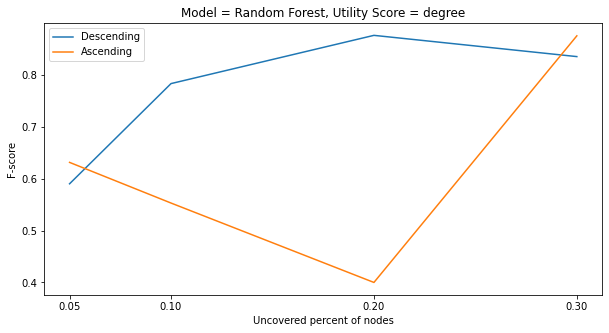

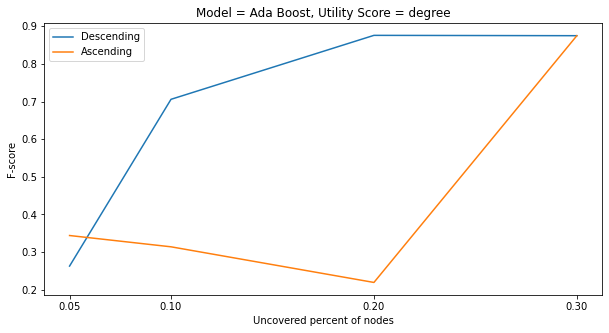

In [93]:
us = list(utility_scores.keys())[2]

for m_k, m_v in models.items():
    draw(f'Model = {m_k}, Utility Score = {us}', 
    'Uncovered percent of nodes', 
    results_ica[(results_ica['model'] == m_k) & (results_ica['utility_score'] == us) & (results_ica['reverce'] == 1.0)],
    results_ica[(results_ica['model'] == m_k) & (results_ica['utility_score'] == us) & (results_ica['reverce'] == 0.0)])

# Częściowe wnioski 1
Zostały przebadane 2 modele: Random Forest oraz AdaBoost. W przypadku algorytmu ICA zostały wybrane 3 miary Utility Score: betweenness, closeness oraz degree. W przypadku każdej miary węzły grafu zostały posortowane malejąco lub rosnąco wg tcyh miar. 
* Niezależnie od wybranego modelu, miary oraz porządku sortowania węzłów wg Utility Score, można osiągnąć bardzo podobne pozytywne wyniki, kiedy zostaną otwarte > 30% etykiet węzłów.
* Wyniki dla obu modeli, kiedy otwarte są < 30% etykiet, są podobne jeśli chodzi o porządek sortowania. W przypdku miar betweenness i degree modele osiągają lepsze wyniki, kiedy wezły są posortowane maljejąco. W przypadku miary closeness - rosnąco.

In [94]:
def draw(title, xlabel, df1, df2, df3):
    fig = plt.figure(figsize=(10,5))
    ax = plt.axes()

    plt.title(f"{title}")
    plt.xlabel(xlabel)
    plt.ylabel("F-score")

    # x = range(1, len(df1) + 1)
    plt.xticks(df1.p2uncover.tolist())
    x = df1.p2uncover.tolist()

    ax.plot(x, df1.fscore.tolist(), label=f'betweenness')
    ax.plot(x, df2.fscore.tolist(), label=f'closeness')
    ax.plot(x, df3.fscore.tolist(), label=f'degree')

    plt.legend()

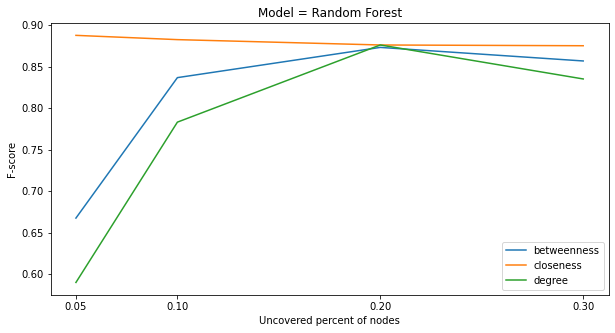

In [96]:
model = list(models.keys())[0]

draw(f'Model = {model}', 
    'Uncovered percent of nodes', 
    results_ica[(results_ica['model'] == model) & (results_ica['utility_score'] == list(utility_scores.keys())[0]) & (results_ica['reverce'] == 1.0)],
    results_ica[(results_ica['model'] == model) & (results_ica['utility_score'] == list(utility_scores.keys())[1]) & (results_ica['reverce'] == 0.0)],
    results_ica[(results_ica['model'] == model) & (results_ica['utility_score'] == list(utility_scores.keys())[2]) & (results_ica['reverce'] == 1.0)])

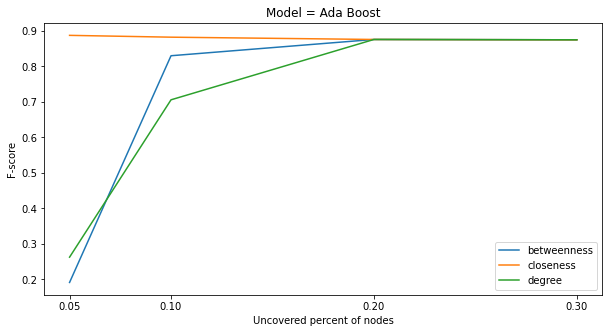

In [97]:
model = list(models.keys())[1]

draw(f'Model = {model}', 
    'Uncovered percent of nodes', 
    results_ica[(results_ica['model'] == model) & (results_ica['utility_score'] == list(utility_scores.keys())[0]) & (results_ica['reverce'] == 1.0)],
    results_ica[(results_ica['model'] == model) & (results_ica['utility_score'] == list(utility_scores.keys())[1]) & (results_ica['reverce'] == 0.0)],
    results_ica[(results_ica['model'] == model) & (results_ica['utility_score'] == list(utility_scores.keys())[2]) & (results_ica['reverce'] == 1.0)])

# Częściowe wnioski 2
* Najlepiej zdaje się sprawdzać miara closeness. Oba modele pokazują Fscore na poziomie 0.88, kiedy procent odkrytych etykiet jest mały 0.05. W porówanianiu do betweenness: 0.2 (AdaBoost), 0.67 (RF) oraz degree: o,28 (Adaboost), 0.59 (RF)

In [100]:
results_random = pd.read_csv('random_results.csv')

In [102]:
results_random

,Unnamed: 0,fscore,model,p2uncover
0,0,0.852174,Random Forest,0.05
1,1,0.864052,Random Forest,0.10
2,2,0.857353,Random Forest,0.20
3,3,0.850420,Random Forest,0.30
4,4,0.833540,Ada Boost,0.05
5,5,0.824837,Ada Boost,0.10
6,6,0.801471,Ada Boost,0.20
7,7,0.803361,Ada Boost,0.30


In [113]:
results_random[results_random['model'] == model]

,Unnamed: 0,fscore,model,p2uncover
0,0,0.852174,Random Forest,0.05
1,1,0.864052,Random Forest,0.10
2,2,0.857353,Random Forest,0.20
3,3,0.850420,Random Forest,0.30


In [109]:
def draw(title, xlabel, df1, df2):
    fig = plt.figure(figsize=(10,5))
    ax = plt.axes()

    plt.title(f"{title}")
    plt.xlabel(xlabel)
    plt.ylabel("F-score")

    # x = range(1, len(df1) + 1)
    plt.xticks(df1.p2uncover.tolist())
    x = df1.p2uncover.tolist()

    ax.plot(x, df1.fscore.tolist(), label=f'ICA')
    ax.plot(x, df2.fscore.tolist(), label=f'Random')

    plt.legend()

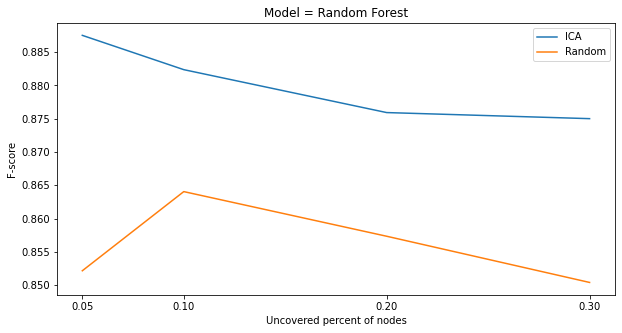

In [114]:
model = list(models.keys())[0]

draw(f'Model = {model}', 
    'Uncovered percent of nodes', 
    results_ica[(results_ica['model'] == model) & (results_ica['utility_score'] == list(utility_scores.keys())[1]) & (results_ica['reverce'] == 0.0)],
    results_random[(results_random['model'] == model)])

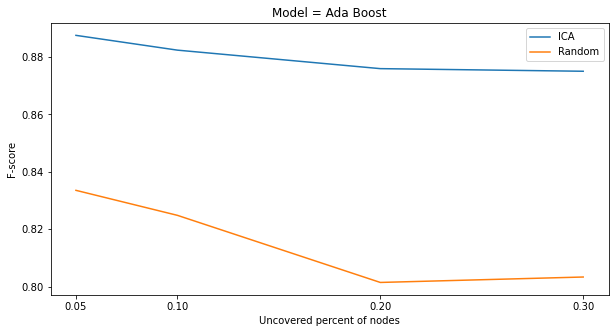

In [115]:
model = list(models.keys())[1]

draw(f'Model = {model}', 
    'Uncovered percent of nodes', 
    results_ica[(results_ica['model'] == model) & (results_ica['utility_score'] == list(utility_scores.keys())[1]) & (results_ica['reverce'] == 0.0)],
    results_random[(results_random['model'] == model)])

# Częściowe wnioski 3
* W przypadku obu modeli wyniki są podobne. Algorytm ICA sprawdza się lepiej niż losowy. Jednak losowy algorytm działa szybciej, a wyniki różnią się maksymalnie o 0.08 Fscore.
* Najlepsze wyniki osiągnąl model Random Forest. Ada Boost jest niewiele gorszy.